<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Imports

In [139]:
import numpy as np
import pickle
import requests

# other imports go here

# Data loading and inspection

In [140]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

# Data augmentation and pipeline

In [141]:
# code for data augmentation pipeline 
unlabeled_data = full_data["unlabeled_data"]
labeled_data = full_data["labeled_data"]
representative_set_1 = full_data["representative_set_1"]
representative_set_2 = full_data["representative_set_2"]

In [142]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, precision_recall_curve, auc

class MyDataset(Dataset):
    def __init__(self, input_data, label_data):
        self.input_data = input_data
        self.label_data = label_data
        # , transforms.RandomRotation(0, 45)
        self.mnist_transform = transforms.Compose([transforms.ToTensor()])
    def __getitem__(self, index):
        input = self.mnist_transform(self.input_data[index]).moveaxis(0,1)
        label = self.label_data[index]
        return input, label
        
    def __len__(self):
        return len(self.input_data)

# Model definitions

In [143]:
# code for model definitions goes here
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3),  # 32@30*30
            nn.BatchNorm2d(32,momentum=1,affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32@15*15

            nn.Conv2d(32, 64, 3), # 64@13*13
            nn.BatchNorm2d(64,momentum=1,affine=True),
            nn.ReLU(inplace=True),    
            nn.MaxPool2d(2),   # 64@6*6
            
            nn.Conv2d(64, 128, 3), #128@4*4
            nn.BatchNorm2d(128,momentum=1,affine=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.liner = nn.Sequential(nn.Linear(2048, 1024), nn.Sigmoid())
        self.fc_input = nn.Sequential(nn.Linear(1024, hidden_dim), nn.ReLU())
        self.fc_hidden = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        h = self.liner(x)
        h = self.fc_input(h)
        h = self.fc_hidden(h)
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        
        return z


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.2))
        self.fc_hidden2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.2))
        self.fc_hidden3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(p=0.2))
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Sigmoid())
        
    def forward(self, x):
        h = self.fc_hidden1(x)
        h = self.fc_hidden2(h)
        h = self.fc_hidden3(h)
        x_reconstr = self.fc_output(h)
        return x_reconstr

class Classifier(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc_input = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU())
        self.fc_hidden_1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_hidden_2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_output = nn.Sequential(nn.Linear(hidden_dim, output_dim), nn.Softmax())

    def forward(self, x):
        h = self.fc_input(x)
        h = self.fc_hidden_1(h)
        h = self.fc_hidden_2(h)
        x = self.fc_output(h)
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        y_pred = self.classifier(z)
        return x_reconstr, mu, log_sigma, y_pred
        # if labeled:
        #     y_pred = self.classifier(z)
        #     return x_reconstr, mu, log_sigma, y_pred
        # else:
        #     return x_reconstr, mu, log_sigma

    def elbo_elementwise(self, x, x_reconstr, mu, log_sigma):
        reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
        constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
        kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
        elbo = - reconstr_loss - constant_term - kl_loss
        return elbo, reconstr_loss, kl_loss

    def predict(self, x, threshold_left, threshold_right, DEVICE):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        x = x.view(x.size()[0], -1)
        elbo, reconstr_loss, kl_loss = self.elbo_elementwise(x, x_reconstr, mu, log_sigma)
        zero = torch.tensor([[0]]).to(device=DEVICE, dtype=torch.float)

        if reconstr_loss.item() > threshold_right or reconstr_loss.item() < threshold_left:
          y_pred = torch.tensor([[0,0,0,0,0,1]]).to(device=DEVICE, dtype=torch.float)
        else:
          y_pred = self.classifier(z)
          y_max = y_pred.argmax(1)
          y_pred = torch.zeros(y_pred.shape).to(device=DEVICE, dtype=torch.float).scatter(1, y_max.unsqueeze (1), 1.0)
          y_pred = torch.cat((y_pred, zero), dim=1)
        return y_pred

    def evaluation(self, batch, batch_size, threshold_left, threshold_right, DEVICE):
        accuracy = 0
        abnormal = torch.tensor([[0,0,0,0,0,1]]).to(device=DEVICE, dtype=torch.float)
        abnormal_count = 0
        for idx in range(batch_size):
            x = batch[0][idx].to(device=DEVICE, dtype=torch.float).unsqueeze(0)
            y = batch[1][idx].to(device=DEVICE, dtype=torch.float)
            y_pred = self.predict(x, threshold_left, threshold_right, DEVICE)
            # print(y_pred, y)
            if torch.eq(y, y_pred).all(dim=1):
                # print(y, y_pred)
                if torch.eq(y, abnormal).all(dim=1):
                    abnormal_count += 1
                accuracy += 1
        return accuracy / batch_size, abnormal_count, accuracy

def loss_function(x, y, x_reconstr, mu, log_sigma, y_pred):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    if torch.any(y).item():
        cross_entropy_loss = torch.sum(-y * torch.log(y_pred) - (1 - y) * torch.log(1 - y_pred))
    else:
        cross_entropy_loss = torch.tensor(0).to(DEVICE, dtype=torch.float)
    total_loss = reconstr_loss + kl_loss + cross_entropy_loss
    return total_loss, reconstr_loss, kl_loss, cross_entropy_loss





# Training and validation loop

In [154]:
# write your training and validation loop here
# hyper parameters
latent_dim = 10
x_dim = 1*32*32 #image dimension
hidden_dim = 500
output_dim = 5 # class category
lr = 1e-4
epochs = 50
batch_size = 100
x_channel = 1
x_size = 32

# data loader
unlabeled_train_data = MyDataset(unlabeled_data, np.full((26000, 5), 0))
unlabeled_train_loder = DataLoader(dataset=unlabeled_train_data, batch_size=batch_size)

# initailize model
cuda = True  # NOTE: if running in Google Colab, make sure to go to "Edit > Notebook settings" and set "Hardware accelerator" to "GPU"
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
classifier = Classifier(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

vae = VAE(encoder=encoder, decoder=decoder, classifier=classifier).to(DEVICE)

# optimizer = Adam(vae.parameters(), lr=lr)
optimizer = torch.optim.SGD(vae.parameters(), lr=lr)

In [155]:
# perform training
print("Start training VAE with unlabeled data...")
vae.train()
overall_losses = []
overall_reconstr_losses = []
overall_kl_losses = []
overall_cross_entropy_losses = []

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    overall_cross_entropy_loss = 0
    n_datapoints = 0
    for batch_idx, (x, y) in enumerate(unlabeled_train_loder):
        x = x.to(device=DEVICE, dtype=torch.float)
        y = y.to(device=DEVICE, dtype=torch.float)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma, _ = vae(x)
        
        x = x.view(batch_size, x_dim)
        loss, reconstr_loss, kl_loss, cross_entropy_loss = loss_function(x, y, x_reconstr, mu, log_sigma, None)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        overall_cross_entropy_loss += cross_entropy_loss.item()
        
        loss.backward()
        optimizer.step()

    n_datapoints = (batch_idx + 1) * batch_size * (epoch + 1)
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints, "\tCross Entropy Loss:", overall_cross_entropy_loss / n_datapoints)
    overall_losses.append(overall_loss / n_datapoints)
    overall_reconstr_losses.append(overall_reconstr_loss / n_datapoints)
    overall_kl_losses.append(overall_kl_loss / n_datapoints)
    overall_cross_entropy_losses.append(overall_cross_entropy_loss / n_datapoints)
    
print("Training1 complete!")


Start training VAE with unlabeled data...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	Epoch 1 	Average Loss:  69.32314770507813 	Reconstruction Loss: 68.17092703951322 	KL Loss: 1.1522206852802863 	Cross Entropy Loss: 0.0
	Epoch 2 	Average Loss:  28.84581434044471 	Reconstruction Loss: 27.781684579702524 	KL Loss: 1.0641297000004695 	Cross Entropy Loss: 0.0
	Epoch 3 	Average Loss:  16.45492600348057 	Reconstruction Loss: 15.330878577599158 	KL Loss: 1.1240473920381986 	Cross Entropy Loss: 0.0
	Epoch 4 	Average Loss:  10.492997783954326 	Reconstruction Loss: 9.622629246638372 	KL Loss: 0.8703685373159555 	Cross Entropy Loss: 0.0
	Epoch 5 	Average Loss:  7.718301906174879 	Reconstruction Loss: 6.944631824669471 	KL Loss: 0.7736700800969051 	Cross Entropy Loss: 0.0
	Epoch 6 	Average Loss:  5.836353454589844 	Reconstruction Loss: 5.104285057654748 	KL Loss: 0.7320683979132236 	Cross Entropy Loss: 0.0
	Epoch 7 	Average Loss:  4.708193785950378 	Reconstruction Loss: 4.051555527236435 	KL Loss: 0.6566382669302133 	Cross Entropy Loss: 0.0
	Epoch 8 	Average Loss:  3.94761128000

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Loss')

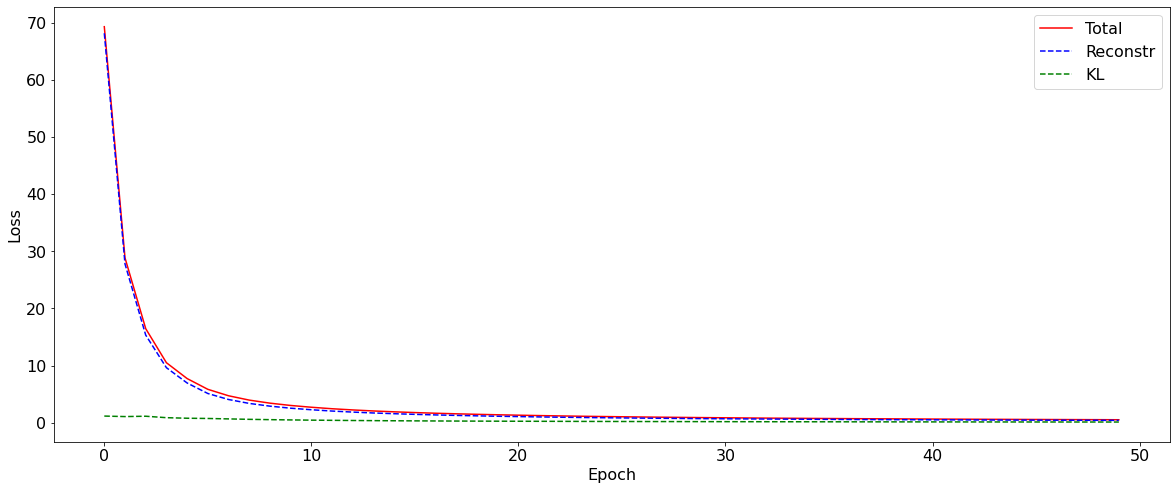

In [157]:
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(20,8))

fnt=16
ax.plot(overall_losses, color='red', label='Total')
ax.plot(overall_reconstr_losses, color='blue', linestyle='--', label='Reconstr')
ax.plot(overall_kl_losses, color='green', linestyle='--', label='KL')
# ax.plot(overall_cross_entropy_losses, color='yellow', linestyle='--', label='Cross Entropy')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt)

In [158]:
# hyper parameters
# latent_dim = 10
# x_dim = 1*32*32 #image dimension
# hidden_dim = 500
# output_dim = 5 # class category
lr = 1e-5
epochs = 100
batch_size = 100
print("Start training VAE with labeled data...")
# data loder
labeled_train_data = MyDataset(labeled_data['data'], labeled_data['labels'])
valid_data =  MyDataset(representative_set_1['data'], representative_set_1['labels'])
labeled_train_loder = DataLoader(dataset=labeled_train_data, batch_size=batch_size)
valid_train_loder = DataLoader(dataset=valid_data, batch_size=batch_size)
optimizer = Adam(vae.parameters(), lr=lr)
overall_losses = []
overall_reconstr_losses = []
overall_kl_losses = []
overall_cross_entropy_losses = []

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    overall_cross_entropy_loss = 0
    for batch_idx, (x, y) in enumerate(labeled_train_loder):
        x = x.to(device=DEVICE, dtype=torch.float)
        y = y.to(device=DEVICE, dtype=torch.float)

        optimizer.zero_grad()

        x_reconstr, mu, log_sigma, y_pred = vae(x)

        x = x.view(batch_size, x_dim)
        loss, reconstr_loss, kl_loss, cross_entropy_loss = loss_function(x, y, x_reconstr, mu, log_sigma, y_pred)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        overall_cross_entropy_loss += cross_entropy_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = (batch_idx + 1) * batch_size * (epoch + 1)
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints, "\tCross Entropy Loss:", overall_cross_entropy_loss / n_datapoints)
    overall_losses.append(overall_loss / n_datapoints)
    overall_reconstr_losses.append(overall_reconstr_loss / n_datapoints)
    overall_kl_losses.append(overall_kl_loss / n_datapoints)
    overall_cross_entropy_losses.append(overall_cross_entropy_loss / n_datapoints)

print("Training2 complete!")

Start training VAE with labeled data...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	Epoch 1 	Average Loss:  27.928865844726563 	Reconstruction Loss: 19.919214904785157 	KL Loss: 5.523462249755859 	Cross Entropy Loss: 2.4861886672973634
	Epoch 2 	Average Loss:  13.853795104980469 	Reconstruction Loss: 9.872462829589844 	KL Loss: 2.7485146942138674 	Cross Entropy Loss: 1.2328175048828125
	Epoch 3 	Average Loss:  9.219440063476563 	Reconstruction Loss: 6.5742661539713545 	KL Loss: 1.8299459533691407 	Cross Entropy Loss: 0.8152278951009114
	Epoch 4 	Average Loss:  6.909297454833984 	Reconstruction Loss: 4.930182342529297 	KL Loss: 1.3734021377563477 	Cross Entropy Loss: 0.605713041305542
	Epoch 5 	Average Loss:  5.487416650390625 	Reconstruction Loss: 3.910881311035156 	KL Loss: 1.0969934265136718 	Cross Entropy Loss: 0.4795419357299805
	Epoch 6 	Average Loss:  4.576857564290364 	Reconstruction Loss: 3.2681719258626303 	KL Loss: 0.9137072550455729 	Cross Entropy Loss: 0.39497827021280923
	Epoch 7 	Average Loss:  3.9188506731305806 	Reconstruction Loss: 2.8018163103376117

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'Loss')

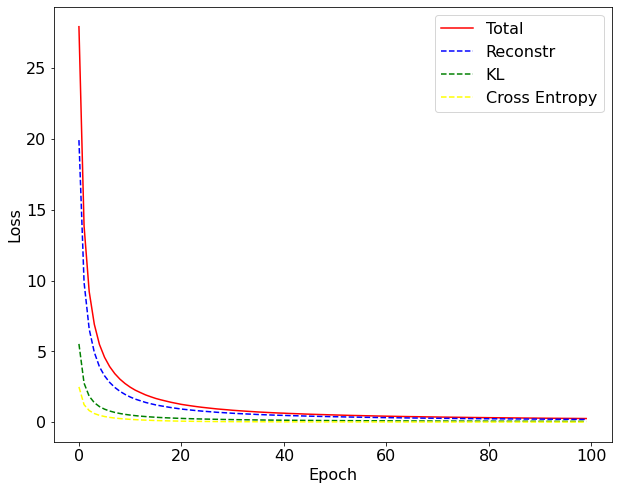

In [159]:
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(overall_losses, color='red', label='Total')
ax.plot(overall_reconstr_losses, color='blue', linestyle='--', label='Reconstr')
ax.plot(overall_kl_losses, color='green', linestyle='--', label='KL')
ax.plot(overall_cross_entropy_losses, color='yellow', linestyle='--', label='Cross Entropy')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt)

# Inspection, Validation, and Analysis

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


elbo


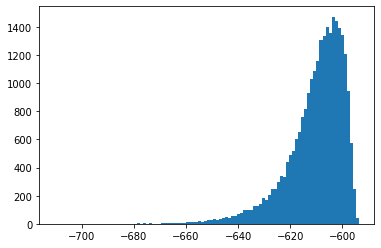

reconstruction loss


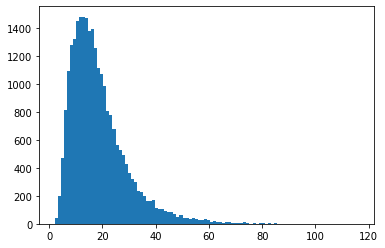

18.625492 10.820949 -3.0164051055908203 40.26738929748535


In [160]:
# Inspect, validate, and analyse your trained model
vae.eval()

normal_elbo = []
# anomaly_test_elbo = []
normal_rec = []
# anomaly_test_rec = []
batch_size = 1000

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(unlabeled_train_loder):
        # print(x.size())
        x = x.to(device=DEVICE, dtype=torch.float)
        y = y.to(device=DEVICE, dtype=torch.float)
        x_rec, mu, log_sigma, _ = vae(x)

        x = x.view(x.size()[0], -1)
        elbo, rec, kl = vae.elbo_elementwise(x, x_rec, mu, log_sigma)
        normal_elbo.append(elbo.cpu().numpy())
        normal_rec.append(rec.cpu().numpy())
    
    normal_elbo = np.concatenate(normal_elbo, 0)
    normal_rec = np.concatenate(normal_rec, 0)

    print('elbo')
    plt.hist(normal_elbo, bins=100)
    plt.show()
    print('reconstruction loss')
    plt.hist(normal_rec, bins=100)
    plt.show()

    mu = np.mean(normal_rec)
    std = np.std(normal_rec)
    threshold_left = mu - 2*std
    threshold_right = mu + 2*std
    print(mu, std, threshold_left, threshold_right)


In [161]:
# evaluation
batch_size = 1052
DEVICE = torch.device("cuda" if cuda else "cpu")
test_data =  MyDataset(representative_set_1['data'], representative_set_1['labels'])
test_train_loder = DataLoader(dataset=test_data, batch_size=batch_size)
print(threshold_left, threshold_right)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_train_loder):
        accuracy = vae.evaluation(batch, batch_size, threshold_left, threshold_right, DEVICE)
        print(accuracy)

-3.0164051055908203 40.26738929748535


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(0.8479087452471483, 34, 892)
